In [0]:
!pip install textstat
!git clone https://github.com/openai/generating-reviews-discovering-sentiment.git
%cd generating-reviews-discovering-sentiment
!pip install tqdm

# Imports and downloads

import pandas as pd
import os
import tensorflow as tf 
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from scipy.sparse import hstack # to concatenate features
from sklearn.svm import LinearSVC
from keras.preprocessing.text import Tokenizer
import nltk
import numpy as np
from nltk.corpus import sentiwordnet as swn, wordnet
from nltk import pos_tag, word_tokenize
from textblob import TextBlob
import textstat
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from gensim.models import KeyedVectors
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from encoder import Model

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

drive.mount("/content/gdrive", force_remount=True)

# Read the data + emotions
df = pd.read_pickle('/content/gdrive/My Drive/datathon/task2data.pkl')

df.describe()

Cloning into 'generating-reviews-discovering-sentiment'...
remote: Enumerating objects: 63, done.
remote: Total 63 (delta 0), reused 0 (delta 0), pack-reused 63
Unpacking objects: 100% (63/63), done.
Checking out files: 100% (24/24), done.
/content/generating-reviews-discovering-sentiment/generating-reviews-discovering-sentiment
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Found GPU at: /device:GPU:0
Mounted at /content/gdrive


,article,N_sentence,sadness,joy,fear,disgust,anger
count,1.426300e+04,14263.000000,14263.000000,14263.000000,14263.000000,14263.000000,14263.000000
mean,9.440644e+08,47.675384,0.257924,0.202204,0.132644,0.171051,0.168878
std,1.145074e+09,55.272256,0.177576,0.192200,0.131431,0.160697,0.143378
min,1.111111e+08,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.289730e+08,14.000000,0.127318,0.052781,0.049964,0.056007,0.067621
50%,7.618971e+08,29.000000,0.222080,0.143389,0.095208,0.116630,0.127791
75%,7.820171e+08,58.000000,0.359406,0.295384,0.169027,0.241330,0.231704
max,7.709564e+09,429.000000,1.000000,1.000000,1.000000,0.931034,1.000000


In [0]:
df.head()

,sentences,article,N_sentence,is_propaganda,sadness,joy,fear,disgust,anger
0,New Audio From The Night Of The Las Vegas Mass...,704856340,1,non-propaganda,0.093891,0.481352,0.238193,0.133129,0.162108
2,Newly released audio from the Clark County Fir...,704856340,3,non-propaganda,0.456951,0.024205,0.162442,0.419307,0.281755
3,"The audio, released on the SoundCloud account ...",704856340,4,non-propaganda,0.193504,0.280196,0.125014,0.140594,0.366930
4,"Intellihub’s Shepard Ambellas, who has extensi...",704856340,5,non-propaganda,0.674633,0.155427,0.046534,0.116447,0.051066
5,“We have a firefighter’s wife at this event wh...,704856340,6,non-propaganda,0.356464,0.171645,0.098791,0.098959,0.272835


In [0]:
pd.set_option('display.max_columns', 500) # to show all columns after we've added more features, there's options to show the entire sentences as well

In [0]:
len(df.loc[df['is_propaganda'] == 'propaganda'])

3938

3938 out of 14263 are propaganda.

In [0]:
# Functions for a single sentence(datapoint)

# Number of words in a sentence
def get_num_words(text):
    
    # Remove special chars and punctuation
    tokens = text.split()
    
    return len(tokens)

# Num of chars
def get_num_chars(text):    
    return len(text)
  
# Num adjectives
def count_adjectives(text):
    num_adjs = 0
    tags = pos_tag(word_tokenize(text.lower()))
    for t in tags:
      if t[1].startswith('JJ'):
        num_adjs += 1
    return num_adjs
  
  
def count_adverbs(text):
    num_adv = 0
    tags = pos_tag(word_tokenize(text.lower()))
    for t in tags:
      if t[1].startswith('RB'):
        num_adv += 1
    return num_adv
  
def count_singular_pronouns(text):
    
    sing_pro = 0
    tags = pos_tag(word_tokenize(text.lower()))
    for t in tags:
      if t[1].startswith('NNP'):
        sing_pro += 1
    return sing_pro
  
  
def count_plural_pronouns(text):
  
    plur_pro = 0
    tags = pos_tag(word_tokenize(text.lower()))
    for t in tags:
      if t[1].startswith('NNP'):
        plur_pro += 1
    return plur_pro

# Type of sentence
def is_question(sentence):
    if len(sentence) == 0:
        return 0
    return 1 if sentence[len(sentence) - 1] == '?' else 0

def is_exclamation(sentence):
    if len(sentence) == 0:
        return 0
    return 1 if sentence[len(sentence) - 1] == '!' else 0

def is_period(sentence):
    if len(sentence) == 0:
        return 0
    return 1 if sentence[len(sentence) - 1] == '.' else 0
  
# Polarity feature

def polarity(sentence):
    """
    :param sentences list of sentences
    :return: a list of singleton lists which contain
             a number between -1 and 1,
             where -1 is negative and 1 is positive.
    """
    return TextBlob(sentence).sentiment.polarity
  
# Subjectivity feature

def subjectivity(sentence):
    """
    :param sentences list of sentences
    :return: a list of singleton lists which contain
            a number between 0 and 1,
            where 0 is objective and 1 is subjective.
    """
    return TextBlob(sentence).sentiment.subjectivity
  
  
def lexical_chars(chars, key_wanted):
    char_count = len(chars)

    possible_chars_map = {
        ',': 'comma_count',
        '\n': 'paragraph_count',
        ';': 'semicolon_count',
        ':': 'colon_count',
        ' ': 'spaces_count',
        '\'': 'apostrophes_count',
        '&': 'amp_count'
    }

    possible_chars = possible_chars_map.keys()

    char_analysis = {
        'digits': 0,
        'punctuation_count': 0,
        'comma_count': 0,
        'semicolon_count': 0,
        'colon_count': 0,
        'spaces_count': 0,
        'apostrophes_count': 0,
        'amp_count': 0,
        'parenthesis_count': 0,
        'paragraph_count': 0
    }

    for char in chars:
        if char in possible_chars:
            char_analysis[possible_chars_map[char]] += 1
        elif char.isdigit(): char_analysis['digits'] += 1
        elif char in ['(', ')']: char_analysis['parenthesis_count'] += 1
        if char in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~': char_analysis['punctuation_count'] += 1

    return char_analysis[key_wanted]/char_count
  
def lexical_words(sent, key_wanted):
    
    entry_word = word_tokenize(sent)
    word_count = len(entry_word)
    words_tagged = pos_tag(entry_word)
    
    word_analysis = {
        'pronouns': 0,
        'prepositions': 0,
        'coordinating_conjunctions': 0,
        'adjectives': 0,
        'adverbs': 0,
        'determiners': 0,
        'interjections': 0,
        'modals': 0,
        'nouns': 0,
        'personal_pronouns': 0,
        'verbs': 0,
        'word_len_gte_six': 0,
        'word_len_two_and_three': 0,
        'avg_word_length': 0,
        'all_caps': 0,
        'capitalized': 0,
        'quotes_count': 0,
    }

    for (word, tag) in words_tagged:
        if tag in ['PRP']: word_analysis['personal_pronouns'] += 1
        if tag.startswith('J'): word_analysis['adjectives'] += 1
        if tag.startswith('N'): word_analysis['nouns'] += 1
        if tag.startswith('V'): word_analysis['verbs'] += 1
        if tag in ['PRP', 'PRP$', 'WP', 'WP$']: word_analysis['pronouns'] += 1
        elif tag in ['IN']: word_analysis['prepositions'] += 1
        elif tag in ['CC']: word_analysis['coordinating_conjunctions'] += 1
        elif tag in ['RB', 'RBR', 'RBS']: word_analysis['adverbs'] += 1
        elif tag in ['DT', 'PDT', 'WDT']: word_analysis['determiners'] += 1
        elif tag in ['UH']: word_analysis['interjections'] += 1
        elif tag in ['MD']: word_analysis['modals'] += 1
        if len(word) >= 6: word_analysis['word_len_gte_six'] += 1
        elif len(word) in [2, 3]: word_analysis['word_len_two_and_three'] += 1
        word_analysis['avg_word_length'] += len(word)
        if word.isupper(): word_analysis['all_caps'] += 1
        elif word[0].isupper(): word_analysis['capitalized'] += 1
        word_analysis['quotes_count'] += word.count('"') + word.count('`') + word.count('\'')

    return word_analysis[key_wanted]/word_count

# Sentiment using synsets from Wordnet
def compute_score(sentence):
    sent_score = []
    words = pos_tag(sentence.split())
    for t in words:
        word = t[0]
        tag = t[1]
        new_tag = ''
        if tag.startswith('NN'):
            new_tag = wordnet.NOUN
        elif tag.startswith('J'):
            new_tag = wordnet.ADJ
        elif tag.startswith('V'):
            new_tag = wordnet.VERB
        elif tag.startswith('R'):
            new_tag = wordnet.ADV

        if new_tag != '':
            synsets = list(swn.senti_synsets(word, new_tag))
            score = 0.0
            if len(synsets) > 0:
                for syn in synsets:
                    score += syn.pos_score() - syn.neg_score()
                sent_score.append(score / len(synsets))

    if len(sent_score)==0:
        return float(0.0)
    else:
        return np.mean(sent_score)

# Finding the proportion of confusing words
def normalized_number_meanings(sentence):
    transformed = []
    tokens = word_tokenize(sentence)
    words_tagged = pos_tag(tokens)
    word_vector = [0,0,0,0]

    # 0 - verbs, 1 - adjectives, 2 - nouns, 3 - adverbs
    confusing_verb_count = 0
    for word, tag in words_tagged:
      if (tag.startswith('VB')):
        word_vector[0] += len(wordnet.synsets(word, pos=wordnet.VERB))
      elif (tag.startswith('JJ')):
        word_vector[1] += len(wordnet.synsets(word, pos=wordnet.ADJ))
      elif (tag.startswith('NN')):
        word_vector[2] += len(wordnet.synsets(word, pos=wordnet.NOUN))
      elif (tag.startswith('RB')):
        word_vector[3] += len(wordnet.synsets(word, pos=wordnet.ADV))    
    
    return (word_vector[0] + word_vector[1] + word_vector[2] + word_vector[3])/len(words_tagged)
  
# Loaded lang - maybe stem here? - list of loaded language phrases(includes words like "sjws", "neo-marxist" or "libtard")
with open('/content/gdrive/My Drive/datathon/loaded_language_phrases_short.txt') as f_loaded_lang:
  loaded_lang=[loaded_word.rstrip().lower() for loaded_word in f_loaded_lang.readlines()]

# Should be changed a bit if a word occurs more than once
def loaded_language_count(sent):
  llc = 0
  sent = sent.lower()
  for loaded_word in loaded_lang:
    if loaded_word in sent:
      llc += 1
  return llc

with open('/content/gdrive/My Drive/datathon/exclamation_words.txt') as f_exlamation_words:
  excl_words=[excl_word.rstrip() for excl_word in f_exlamation_words.readlines()]

def excl_words_count(sent):
  ewc = 0
  sent = sent.lower().split()
  for w in sent:
    if w in excl_words:
      ewc += 1
  return ewc

# To add to the features

sentences_list = df['sentences'].tolist()

model = Model()

text_features = model.transform(sentences_list)
text_features = text_features[:, 2388]

df['sentiment_neuron'] = text_features

      
# Apply the transformations to all sentences
df['ewc'] = df['sentences'].apply(excl_words_count)
      
df['llc'] = df['sentences'].apply(loaded_language_count)


## Number of unique words in the text ##
df["num_unique_words"] = df["sentences"].apply(lambda x: len(set(str(x).split())))

## Number of stopwords in the text ##
df["num_stop_words"] = df["sentences"].apply(lambda x: len([w for w in str(x).lower().split() if w in ENGLISH_STOP_WORDS]))

## Number of title case words in the text ##
df["num_words_title"] = df["sentences"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

df['normalized_meanings'] = df['sentences'].apply(normalized_number_meanings)
df['sentiment_score'] = df['sentences'].apply(compute_score)

# Lexical words features
df['pronouns'] = df['sentences'].apply(lambda x: lexical_words(x, 'pronouns'))
df['prepositions'] = df['sentences'].apply(lambda x: lexical_words(x, 'prepositions'))
df['coordinating_conjunctions'] = df['sentences'].apply(lambda x: lexical_words(x, 'coordinating_conjunctions'))
df['adjectives'] = df['sentences'].apply(lambda x: lexical_words(x, 'adjectives'))
df['adverbs'] = df['sentences'].apply(lambda x: lexical_words(x, 'adverbs'))
df['determiners'] = df['sentences'].apply(lambda x: lexical_words(x, 'determiners'))
df['interjections'] = df['sentences'].apply(lambda x: lexical_words(x, 'interjections'))
df['modals'] = df['sentences'].apply(lambda x: lexical_words(x, 'modals'))
df['nouns'] = df['sentences'].apply(lambda x: lexical_words(x, 'nouns'))
df['personal_pronouns'] = df['sentences'].apply(lambda x: lexical_words(x, 'personal_pronouns'))
df['verbs'] = df['sentences'].apply(lambda x: lexical_words(x, 'verbs'))
df['word_len_gte_six'] = df['sentences'].apply(lambda x: lexical_words(x, 'word_len_gte_six'))
df['word_len_two_and_three'] = df['sentences'].apply(lambda x: lexical_words(x, 'word_len_two_and_three'))
df['avg_word_length'] = df['sentences'].apply(lambda x: lexical_words(x, 'avg_word_length'))
df['all_caps'] = df['sentences'].apply(lambda x: lexical_words(x, 'all_caps'))
df['capitalized'] = df['sentences'].apply(lambda x: lexical_words(x, 'capitalized'))
df['quotes_count'] = df['sentences'].apply(lambda x: lexical_words(x, 'quotes_count'))

# Lexical chars features
df['digits'] = df['sentences'].apply(lambda x: lexical_chars(x, 'digits'))
df['punctuation_count'] = df['sentences'].apply(lambda x: lexical_chars(x, 'punctuation_count'))
df['comma_count'] = df['sentences'].apply(lambda x: lexical_chars(x, 'comma_count'))
df['semicolon_count'] = df['sentences'].apply(lambda x: lexical_chars(x, 'semicolon_count'))
df['colon_count'] = df['sentences'].apply(lambda x: lexical_chars(x, 'colon_count'))
df['spaces_count'] = df['sentences'].apply(lambda x: lexical_chars(x, 'spaces_count'))
df['apostrophes_count'] = df['sentences'].apply(lambda x: lexical_chars(x, 'apostrophes_count'))
df['amp_count'] = df['sentences'].apply(lambda x: lexical_chars(x, 'amp_count'))
df['parenthesis_count'] = df['sentences'].apply(lambda x: lexical_chars(x, 'parenthesis_count'))
df['paragraph_count'] = df['sentences'].apply(lambda x: lexical_chars(x, 'paragraph_count'))

# Readability features

df['flesch_reading_ease'] = df['sentences'].apply(textstat.flesch_reading_ease)
df['smog_index'] = df['sentences'].apply(textstat.smog_index)
df['flesch_kincaid_grade'] = df['sentences'].apply(textstat.flesch_kincaid_grade)
df['coleman_liau_index'] = df['sentences'].apply(textstat.coleman_liau_index)
df['automated_readability_index'] = df['sentences'].apply(textstat.automated_readability_index)
df['dale_chall_readability_score'] = df['sentences'].apply(textstat.dale_chall_readability_score)
df['difficult_words'] = df['sentences'].apply(textstat.difficult_words)
df['linsear_write_formula'] = df['sentences'].apply(textstat.linsear_write_formula)
df['gunning_fog'] = df['sentences'].apply(textstat.gunning_fog)

df['subjectivity'] = df['sentences'].apply(subjectivity)
df['polarity'] = df['sentences'].apply(polarity)
df['is_question'] = df['sentences'].apply(is_question)
df['is_exclamation'] = df['sentences'].apply(is_exclamation)
df['is_period'] = df['sentences'].apply(is_period)

df['num_words'] = df['sentences'].apply(get_num_words)
df['num_chars'] = df['sentences'].apply(get_num_chars)

df['num_adjs'] = df['sentences'].apply(count_adjectives)
df['num_adv'] = df['sentences'].apply(count_adverbs)
df['sing_pro'] = df['sentences'].apply(count_singular_pronouns)
df['pl_pro'] = df['sentences'].apply(count_plural_pronouns)

# model = Model()

# def sentiment_neuron(sent):
#   text = [sent]
#   text_features = model.transform(text)
#   return text_features[:, 2388][0]

# df['sentiment_neuron'] = df['sentences'].apply(sentiment_neuron)



print(df.shape)
print(df.columns)
SEED = 666

df['target'] = df['is_propaganda'].map({'propaganda': 1, 'non-propaganda': 0})
y = df[['target']]

df.drop(['article', 'N_sentence', 'is_propaganda'], axis=1, inplace=True)

df.to_pickle('/content/gdrive/My Drive/datathon/task2data_features.pkl')
y.to_pickle('/content/gdrive/My Drive/datathon/labels.pkl')

X_train, X_rest, y_train, y_rest = train_test_split(
        df, y,stratify=y, test_size=0.2, random_state=SEED)

print(X_train.shape)

X_val, X_test, y_val, y_test = train_test_split(
        X_rest, y_rest,stratify=y_rest, test_size=0.5, random_state=SEED)

print(X_val.shape)

# Maybe try different params/vectorisers, stemming etc.? - got these from the winning system for task 1.
vectorizer = TfidfVectorizer(min_df = 3, max_df=0.5,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

x_train_tfidf = vectorizer.fit_transform(X_train['sentences'])
x_val_tfidf = vectorizer.transform(X_val['sentences'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
dim is deprecated, use axis instead
221.854 seconds to transform 14263 examples
(14263, 64)
Index(['sentences', 'article', 'N_sentence', 'is_propaganda', 'sadness', 'joy',
       'fear', 'disgust', 'anger', 'sentiment_neuron', 'ewc', 'llc',
       'num_unique_words', 'num_stop_words', 'num_words_title',
       'normalized_meanings', 'sentiment_score', 'pronouns', 'prepositions',
       'coordinating_conjunctions', 'adjectives', 'adverbs', 'determiners',
       'interjections', 'modals', 'nouns', 'personal_pronouns', 'verbs',
       'word_len_gte_six', 'word_len_two_and_three', 'avg_word_length',
       'all_caps', 'capitalized', 'quotes_count', 'digits',
       'punctuation_count', 'comma_count', 'semicolon_count', 'colon_count',
       'spaces_count', 'apostrophes_count', 'amp_count', 'parenthesis_count',
       'paragraph_count', 'flesch_reading_ease', 'smog_index',
       'flesch_kinca

In [0]:
df.head()

,sentences,sadness,joy,fear,disgust,anger,sentiment_neuron,ewc,llc,num_unique_words,num_stop_words,num_words_title,normalized_meanings,sentiment_score,pronouns,prepositions,coordinating_conjunctions,adjectives,adverbs,determiners,interjections,modals,nouns,personal_pronouns,verbs,word_len_gte_six,word_len_two_and_three,avg_word_length,all_caps,capitalized,quotes_count,digits,punctuation_count,comma_count,semicolon_count,colon_count,spaces_count,apostrophes_count,amp_count,parenthesis_count,paragraph_count,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog,subjectivity,polarity,is_question,is_exclamation,is_period,num_words,num_chars,num_adjs,num_adv,sing_pro,pl_pro,target
0,New Audio From The Night Of The Las Vegas Mass...,0.093891,0.481352,0.238193,0.133129,0.162108,0.277048,0,1,25,16,31,2.242424,-0.015672,0.000000,0.212121,0.000000,0.000000,0.000000,0.212121,0.0,0.000000,0.515152,0.000000,0.030303,0.242424,0.484848,4.060606,0.0,0.939394,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.182927,0.0,0.0,0.0,0.0,56.93,0.0,13.0,8.37,14.4,8.74,7,16.5,21.43,0.518182,0.167677,0,0,0,31,164,3,0,0,0,0
2,Newly released audio from the Clark County Fir...,0.456951,0.024205,0.162442,0.419307,0.281755,0.316485,0,3,53,28,10,3.700000,-0.020672,0.016667,0.150000,0.016667,0.083333,0.133333,0.116667,0.0,0.000000,0.283333,0.000000,0.133333,0.383333,0.200000,5.100000,0.0,0.166667,0.0,0.005510,0.005510,0.002755,0.0,0.000000,0.157025,0.0,0.0,0.0,0.0,4.15,0.0,27.1,14.00,32.4,11.14,17,38.0,34.92,0.364935,-0.051948,0,0,1,58,363,5,8,0,0,0
3,"The audio, released on the SoundCloud account ...",0.193504,0.280196,0.125014,0.140594,0.366930,0.126700,0,4,47,33,5,3.030769,0.008053,0.000000,0.200000,0.015385,0.015385,0.030769,0.200000,0.0,0.000000,0.384615,0.000000,0.061538,0.292308,0.369231,4.430769,0.0,0.092308,0.0,0.000000,0.008596,0.005731,0.0,0.000000,0.174785,0.0,0.0,0.0,0.0,25.47,0.0,25.1,10.29,31.5,10.53,15,36.0,34.48,0.222222,0.086111,0,0,1,62,349,2,2,0,0,0
4,"Intellihub’s Shepard Ambellas, who has extensi...",0.674633,0.155427,0.046534,0.116447,0.051066,0.172019,0,5,38,22,3,2.918367,0.019509,0.061224,0.142857,0.000000,0.040816,0.061224,0.122449,0.0,0.020408,0.285714,0.020408,0.163265,0.367347,0.326531,4.897959,0.0,0.081633,0.0,0.017668,0.021201,0.007067,0.0,0.007067,0.151943,0.0,0.0,0.0,0.0,18.36,0.0,21.6,14.46,26.2,11.20,15,32.0,31.24,0.385000,0.070000,0,0,1,44,283,3,3,1,1,0
5,“We have a firefighter’s wife at this event wh...,0.356464,0.171645,0.098791,0.098959,0.272835,0.307153,0,2,17,10,3,2.954545,-0.015931,0.090909,0.136364,0.000000,0.000000,0.000000,0.136364,0.0,0.000000,0.363636,0.045455,0.181818,0.181818,0.363636,3.500000,0.0,0.136364,0.0,0.000000,0.010638,0.000000,0.0,0.000000,0.180851,0.0,0.0,0.0,0.0,87.05,0.0,5.6,6.90,7.7,6.28,2,9.0,11.64,0.494444,-0.277778,0,0,1,18,94,0,0,1,1,0


In [0]:
print('aa')

aa


In [0]:
group_features = {'subjectivity_and_polarity':['subjectivity', 'polarity'], 'sentence_type':['is_question', 'is_exclamation', 'is_period'], 
                  'emotions':['sadness',	'joy',	'fear',	'disgust',	'anger'], 
                  'readability':['flesch_reading_ease', 'smog_index', 'flesch_kincaid_grade', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'difficult_words', 'linsear_write_formula', 'gunning_fog'], 
                  'tf-idf':['sentences'],  'exclamation_words':['ewc'], 
                  'lexical_chars':['digits', 'punctuation_count', 'comma_count', 'semicolon_count', 'colon_count', 'spaces_count', 'apostrophes_count', 'amp_count', 'parenthesis_count', 'paragraph_count'], 
                  'lexical_words':['pronouns', 'prepositions', 'coordinating_conjunctions', 'adjectives', 'adverbs', 'determiners', 'interjections', 'modals', 'nouns', 'personal_pronouns', 'verbs', 
                                   'word_len_gte_six', 'word_len_two_and_three', 'avg_word_length', 'all_caps', 'capitalized', 'quotes_count'],
                  'loaded_language':['llc'],
                  'confusing_words':['normalized_meanings'],
                  'sentiment':['sentiment_score'],
                  'sentiment_neuron':['sentiment_neuron'],
                  'pos':['num_adjs', 'num_adv', 'sing_pro', 'pl_pro'],
                  'unique_words':['num_unique_words'],
                  'stop_words':['num_stop_words'],
                  'title_case_words':['num_words_title'],
                  'total_counts':['num_words', 'num_chars']
                 }  



In [0]:
print(list(group_features.keys()))

['subjectivity_and_polarity', 'sentence_type', 'emotions', 'readability', 'tf-idf', 'loaded_words', 'exclamation_words', 'lexical_chars', 'lexical_words', 'emotion_exclamations', 'loaded_language', 'confusing_words', 'sentiment', 'sentiment_neuron', 'pos', 'unique_words', 'stop_words', 'title_case_words', 'total_counts']


In [0]:
def train_and_test(classifier, features):
  """
  param::features - of form [('polarity', False), ('emotions', True)], where the
  first elem of the tuple is the feature group name, and the second is whether
  to use scaling or not
  """
  include_tf_idf = False
  # don't use tf idf with scale?
  feats_dataset = []
  feats_to_scale = []
  for feat, scale in features:
    feats_dataset += group_features[feat]
    if scale:
      feats_to_scale += group_features[feat]
  
  if 'sentences' in feats_dataset:
    include_tf_idf = True
    # Maybe try different params/vectorisers, stemming etc.? - got these from the winning system for task 1.
    vectorizer = TfidfVectorizer(min_df = 3, max_df=0.5,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')
  
    x_train = vectorizer.fit_transform(X_train['sentences'])
    x_val = vectorizer.transform(X_rest['sentences'])
    feats_dataset.remove('sentences')
  
  scaler = StandardScaler()
  X_train_copy = X_train[feats_dataset].copy()
  X_rest_copy = X_rest[feats_dataset].copy()
  if feats_to_scale:
    X_train_copy[feats_to_scale] = scaler.fit_transform(X_train_copy[feats_to_scale])
    X_rest_copy[feats_to_scale] = scaler.transform(X_rest_copy[feats_to_scale])
  
  if include_tf_idf:
    classifier.fit(hstack([x_train, X_train_copy[feats_dataset].values]), y_train.values.ravel())
    # All features
    y_pred = classifier.predict(hstack([x_val, X_rest_copy[feats_dataset].values]))
  else:
    classifier.fit(X_train_copy[feats_dataset], y_train.values.ravel())
    y_pred = classifier.predict(X_rest_copy[feats_dataset])
  print(classification_report(y_rest.values.ravel(), y_pred))
  return y_pred


In [0]:
predictions = [ mlp_preds,random_forrest_preds, neigh_clf_preds, lin_svc_preds, svm_preds, nb_preds, baseline_preds]
names = [ 'Perceptron','random forrest','KNN','Linear SVM', 'SVM', 'Gaussian Naive Bayes', 'Random Choice']
results = []
plt.figure(0)
for i,n in zip(predictions,names):
    res = [n]
    p = precision_score(y_test['propaganda'], i, average='binary')
    r = recall_score(y_test['propaganda'], i, average='binary')
    plt.scatter(p,r, label=n,marker='^', s=100)
    res.append(p)
    res.append(r)
    res.append(f1_score(y_test['propaganda'], i, average='binary'))
    results.append(res)
plt.legend()
plt.title("Classification system results")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.tight_layout()
plt.savefig('classification_results.pdf')

In [0]:
group_features.keys()

dict_keys(['subjectivity_and_polarity', 'sentence_type', 'emotions', 'readability', 'tf-idf', 'exclamation_words', 'lexical_chars', 'lexical_words', 'emotion_exclamations', 'loaded_language', 'confusing_words', 'sentiment', 'sentiment_neuron', 'pos', 'unique_words', 'stop_words', 'title_case_words', 'total_counts'])

In [0]:
to_test = ['subjectivity_and_polarity', 'sentence_type', 'emotions', 'readability', 'tf-idf', 'exclamation_words', 'lexical_chars', 'lexical_words', 'loaded_language', 'confusing_words', 'sentiment', 'sentiment_neuron', 'unique_words', 'stop_words', 'total_counts']

In [0]:
to_test

['subjectivity_and_polarity',
 'sentence_type',
 'emotions',
 'readability',
 'tf-idf',
 'exclamation_words',
 'lexical_chars',
 'lexical_words',
 'loaded_language',
 'confusing_words',
 'sentiment',
 'sentiment_neuron',
 'unique_words',
 'stop_words',
 'total_counts']

In [0]:
names = ['Subjectivity/Polarity', 'Sentence Type', 'Emotions', 'Readability', 'Tf-Idf', 'Exclamation Words', 'Lexical Chars', 'Lexical Words', 
         'Loaded Language', 'Ambiguous Words', 'Sentiment', 'Sentiment Neuron', 'Unique Words', 'Stop Words', 'Total Counts']

In [0]:
len(to_test)

15

In [0]:
# LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED)

In [0]:
from sklearn.metrics import f1_score, recall_score, precision_score

predictions = []
for t in to_test:
  print(t)
  y_feat = train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [(t, False)])
  predictions.append(y_feat)

# for t in to_test:
#   train_and_test(LogisticRegression(random_state=SEED), [(t, False)])

subjectivity_and_polarity
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      2065
           1       0.34      0.52      0.41       788

   micro avg       0.59      0.59      0.59      2853
   macro avg       0.56      0.57      0.55      2853
weighted avg       0.65      0.59      0.61      2853

sentence_type
              precision    recall  f1-score   support

           0       0.77      0.23      0.36      2065
           1       0.29      0.82      0.43       788

   micro avg       0.39      0.39      0.39      2853
   macro avg       0.53      0.52      0.39      2853
weighted avg       0.64      0.39      0.38      2853

emotions
              precision    recall  f1-score   support

           0       0.82      0.58      0.68      2065
           1       0.37      0.66      0.48       788

   micro avg       0.60      0.60      0.60      2853
   macro avg       0.60      0.62      0.58      2853
weighted avg       0.70  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.85      0.80      2065
           1       0.42      0.28      0.34       788

   micro avg       0.70      0.70      0.70      2853
   macro avg       0.59      0.57      0.57      2853
weighted avg       0.66      0.70      0.67      2853

tf-idf
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      2065
           1       0.48      0.57      0.52       788

   micro avg       0.71      0.71      0.71      2853
   macro avg       0.65      0.66      0.65      2853
weighted avg       0.73      0.71      0.71      2853

exclamation_words
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.33      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.53      0.50      0.42      2853
weighted avg       0.62      0.72      0.61      

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.52      0.63      2065
           1       0.34      0.63      0.44       788

   micro avg       0.55      0.55      0.55      2853
   macro avg       0.56      0.58      0.54      2853
weighted avg       0.66      0.55      0.58      2853

loaded_language


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.74      0.76      2065
           1       0.38      0.40      0.39       788

   micro avg       0.65      0.65      0.65      2853
   macro avg       0.57      0.57      0.57      2853
weighted avg       0.66      0.65      0.65      2853

confusing_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.46      0.56      2065
           1       0.28      0.55      0.37       788

   micro avg       0.48      0.48      0.48      2853
   macro avg       0.50      0.51      0.47      2853
weighted avg       0.60      0.48      0.51      2853

sentiment
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      2065
           1       0.31      0.46      0.37       788

   micro avg       0.57      0.57      0.57      2853
   macro avg       0.53      0.53      0.52      2853
weighted avg       0.63      0.57      0.59      2853

sentiment_neuron
              precision    recall  f1-score   support

           0       0.76      0.56      0.65      2065
           1       0.32      0.54      0.40       788

   micro avg       0.56      0.56      0.56      2853
   macro avg       0.54      0.55      0.52      2853
weighted avg       0.64      0.56      0.58    

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.00      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.36      0.50      0.42      2853
weighted avg       0.52      0.72      0.61      2853

stop_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2065
           1       0.39      0.39      0.39       788

   micro avg       0.66      0.66      0.66      2853
   macro avg       0.58      0.58      0.58      2853
weighted avg       0.66      0.66      0.66      2853

total_counts
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.00      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.36      0.50      0.42      2853
weighted avg       0.52      0.72      0.61      2853



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
len(predictions)

15

In [0]:
from sklearn.metrics import f1_score, recall_score, precision_score

predictions = []
for t in to_test:
  print(t)
  y_feat = train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [(t, False)])
  predictions.append(y_feat)

# for t in to_test:
#   train_and_test(LogisticRegression(random_state=SEED), [(t, False)])

subjectivity_and_polarity
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      2065
           1       0.34      0.52      0.41       788

   micro avg       0.59      0.59      0.59      2853
   macro avg       0.56      0.57      0.55      2853
weighted avg       0.65      0.59      0.61      2853

sentence_type
              precision    recall  f1-score   support

           0       0.77      0.23      0.36      2065
           1       0.29      0.82      0.43       788

   micro avg       0.39      0.39      0.39      2853
   macro avg       0.53      0.52      0.39      2853
weighted avg       0.64      0.39      0.38      2853

emotions
              precision    recall  f1-score   support

           0       0.82      0.58      0.68      2065
           1       0.37      0.66      0.48       788

   micro avg       0.60      0.60      0.60      2853
   macro avg       0.60      0.62      0.58      2853
weighted avg       0.70  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.85      0.80      2065
           1       0.42      0.28      0.34       788

   micro avg       0.70      0.70      0.70      2853
   macro avg       0.59      0.57      0.57      2853
weighted avg       0.66      0.70      0.67      2853

tf-idf
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      2065
           1       0.48      0.57      0.52       788

   micro avg       0.71      0.71      0.71      2853
   macro avg       0.65      0.66      0.65      2853
weighted avg       0.73      0.71      0.71      2853

exclamation_words
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.33      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.53      0.50      0.42      2853
weighted avg       0.62      0.72      0.61      

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.52      0.63      2065
           1       0.34      0.63      0.44       788

   micro avg       0.55      0.55      0.55      2853
   macro avg       0.56      0.58      0.54      2853
weighted avg       0.66      0.55      0.58      2853

loaded_language


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.74      0.76      2065
           1       0.38      0.40      0.39       788

   micro avg       0.65      0.65      0.65      2853
   macro avg       0.57      0.57      0.57      2853
weighted avg       0.66      0.65      0.65      2853

confusing_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.46      0.56      2065
           1       0.28      0.55      0.37       788

   micro avg       0.48      0.48      0.48      2853
   macro avg       0.50      0.51      0.47      2853
weighted avg       0.60      0.48      0.51      2853

sentiment
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      2065
           1       0.31      0.46      0.37       788

   micro avg       0.57      0.57      0.57      2853
   macro avg       0.53      0.53      0.52      2853
weighted avg       0.63      0.57      0.59      2853

sentiment_neuron
              precision    recall  f1-score   support

           0       0.76      0.56      0.65      2065
           1       0.32      0.54      0.40       788

   micro avg       0.56      0.56      0.56      2853
   macro avg       0.54      0.55      0.52      2853
weighted avg       0.64      0.56      0.58    

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.00      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.36      0.50      0.42      2853
weighted avg       0.52      0.72      0.61      2853

stop_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2065
           1       0.39      0.39      0.39       788

   micro avg       0.66      0.66      0.66      2853
   macro avg       0.58      0.58      0.58      2853
weighted avg       0.66      0.66      0.66      2853

total_counts
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.00      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.36      0.50      0.42      2853
weighted avg       0.52      0.72      0.61      2853



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
len(predictions)

15

In [0]:
from sklearn.linear_model import LogisticRegression

for t in to_test:
  print(t)
  train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [(t, False)])


# for t in to_test:
#   train_and_test(LogisticRegression(random_state=SEED), [(t, False)])

subjectivity_and_polarity
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      2065
           1       0.34      0.52      0.41       788

   micro avg       0.59      0.59      0.59      2853
   macro avg       0.56      0.57      0.55      2853
weighted avg       0.65      0.59      0.61      2853

sentence_type
              precision    recall  f1-score   support

           0       0.77      0.23      0.36      2065
           1       0.29      0.82      0.43       788

   micro avg       0.39      0.39      0.39      2853
   macro avg       0.53      0.52      0.39      2853
weighted avg       0.64      0.39      0.38      2853

emotions
              precision    recall  f1-score   support

           0       0.82      0.58      0.68      2065
           1       0.37      0.66      0.48       788

   micro avg       0.60      0.60      0.60      2853
   macro avg       0.60      0.62      0.58      2853
weighted avg       0.70  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.85      0.80      2065
           1       0.42      0.28      0.34       788

   micro avg       0.70      0.70      0.70      2853
   macro avg       0.59      0.57      0.57      2853
weighted avg       0.66      0.70      0.67      2853

tf-idf
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      2065
           1       0.48      0.57      0.52       788

   micro avg       0.71      0.71      0.71      2853
   macro avg       0.65      0.66      0.65      2853
weighted avg       0.73      0.71      0.71      2853

exclamation_words
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.33      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.53      0.50      0.42      2853
weighted avg       0.62      0.72      0.61      

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.52      0.63      2065
           1       0.34      0.63      0.44       788

   micro avg       0.55      0.55      0.55      2853
   macro avg       0.56      0.58      0.54      2853
weighted avg       0.66      0.55      0.58      2853

emotion_exclamations
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.33      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.53      0.50      0.42      2853
weighted avg       0.62      0.72      0.61      2853

loaded_language


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.74      0.76      2065
           1       0.38      0.40      0.39       788

   micro avg       0.65      0.65      0.65      2853
   macro avg       0.57      0.57      0.57      2853
weighted avg       0.66      0.65      0.65      2853

confusing_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.46      0.56      2065
           1       0.28      0.55      0.37       788

   micro avg       0.48      0.48      0.48      2853
   macro avg       0.50      0.51      0.47      2853
weighted avg       0.60      0.48      0.51      2853

sentiment
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      2065
           1       0.31      0.46      0.37       788

   micro avg       0.57      0.57      0.57      2853
   macro avg       0.53      0.53      0.52      2853
weighted avg       0.63      0.57      0.59      2853

sentiment_neuron
              precision    recall  f1-score   support

           0       0.76      0.56      0.65      2065
           1       0.32      0.54      0.40       788

   micro avg       0.56      0.56      0.56      2853
   macro avg       0.54      0.55      0.52      2853
weighted avg       0.64      0.56      0.58    

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.69      0.74      2065
           1       0.38      0.50      0.43       788

   micro avg       0.64      0.64      0.64      2853
   macro avg       0.58      0.60      0.59      2853
weighted avg       0.67      0.64      0.65      2853

unique_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.00      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.36      0.50      0.42      2853
weighted avg       0.52      0.72      0.61      2853

stop_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2065
           1       0.39      0.39      0.39       788

   micro avg       0.66      0.66      0.66      2853
   macro avg       0.58      0.58      0.58      2853
weighted avg       0.66      0.66      0.66      2853

title_case_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.68      0.71      2065
           1       0.31      0.39      0.35       788

   micro avg       0.60      0.60      0.60      2853
   macro avg       0.53      0.53      0.53      2853
weighted avg       0.62      0.60      0.61      2853

total_counts
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.00      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.36      0.50      0.42      2853
weighted avg       0.52      0.72      0.61      2853



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.linear_model import LogisticRegression

for t in to_test:
  print(t)
  train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [(t, False)])


# for t in to_test:
#   train_and_test(LogisticRegression(random_state=SEED), [(t, False)])

subjectivity_and_polarity
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      2065
           1       0.34      0.52      0.41       788

   micro avg       0.59      0.59      0.59      2853
   macro avg       0.56      0.57      0.55      2853
weighted avg       0.65      0.59      0.61      2853

sentence_type
              precision    recall  f1-score   support

           0       0.77      0.23      0.36      2065
           1       0.29      0.82      0.43       788

   micro avg       0.39      0.39      0.39      2853
   macro avg       0.53      0.52      0.39      2853
weighted avg       0.64      0.39      0.38      2853

emotions
              precision    recall  f1-score   support

           0       0.82      0.58      0.68      2065
           1       0.37      0.66      0.48       788

   micro avg       0.60      0.60      0.60      2853
   macro avg       0.60      0.62      0.58      2853
weighted avg       0.70  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.85      0.80      2065
           1       0.42      0.28      0.34       788

   micro avg       0.70      0.70      0.70      2853
   macro avg       0.59      0.57      0.57      2853
weighted avg       0.66      0.70      0.67      2853

exclamation_words
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.33      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.53      0.50      0.42      2853
weighted avg       0.62      0.72      0.61      2853

lexical_chars
              precision    recall  f1-score   support

           0       0.81      0.31      0.45      2065
           1       0.31      0.81      0.45       788

   micro avg       0.45      0.45      0.45      2853
   macro avg       0.56      0.56      0.45      2853
weighted avg       0.67      0.45      0.4

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.52      0.63      2065
           1       0.34      0.63      0.44       788

   micro avg       0.55      0.55      0.55      2853
   macro avg       0.56      0.58      0.54      2853
weighted avg       0.66      0.55      0.58      2853

emotion_exclamations
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.33      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.53      0.50      0.42      2853
weighted avg       0.62      0.72      0.61      2853

loaded_language


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.74      0.76      2065
           1       0.38      0.40      0.39       788

   micro avg       0.65      0.65      0.65      2853
   macro avg       0.57      0.57      0.57      2853
weighted avg       0.66      0.65      0.65      2853

confusing_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.46      0.56      2065
           1       0.28      0.55      0.37       788

   micro avg       0.48      0.48      0.48      2853
   macro avg       0.50      0.51      0.47      2853
weighted avg       0.60      0.48      0.51      2853

sentiment
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      2065
           1       0.31      0.46      0.37       788

   micro avg       0.57      0.57      0.57      2853
   macro avg       0.53      0.53      0.52      2853
weighted avg       0.63      0.57      0.59      2853

pos


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.69      0.74      2065
           1       0.38      0.50      0.43       788

   micro avg       0.64      0.64      0.64      2853
   macro avg       0.58      0.60      0.59      2853
weighted avg       0.67      0.64      0.65      2853

unique_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.00      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.36      0.50      0.42      2853
weighted avg       0.52      0.72      0.61      2853

stop_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2065
           1       0.39      0.39      0.39       788

   micro avg       0.66      0.66      0.66      2853
   macro avg       0.58      0.58      0.58      2853
weighted avg       0.66      0.66      0.66      2853

title_case_words


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.68      0.71      2065
           1       0.31      0.39      0.35       788

   micro avg       0.60      0.60      0.60      2853
   macro avg       0.53      0.53      0.53      2853
weighted avg       0.62      0.60      0.61      2853

total_counts
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2065
           1       0.00      0.00      0.00       788

   micro avg       0.72      0.72      0.72      2853
   macro avg       0.36      0.50      0.42      2853
weighted avg       0.52      0.72      0.61      2853



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.linear_model import LogisticRegression

for t in to_test:
  train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [(t, False)])


# for t in to_test:
#   train_and_test(LogisticRegression(random_state=SEED), [(t, False)])

0.41768579492003766
0.395864106351551
0.4211229946524065
0.478021978021978
0.40909090909090906


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3107692307692308


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3591087811271298
0.0
0.4545454545454546


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.44326241134751765
0.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3591087811271298


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3655172413793104
0.39199157007376184


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.40969162995594716


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3798449612403101


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.34118967452300786
0.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Second param of the tuple is if we should apply scaling or not to check if it will improve performance
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('polarity', False)])

              precision    recall  f1-score   support

           0       0.73      0.33      0.45      1032
           1       0.28      0.68      0.40       394

   micro avg       0.43      0.43      0.43      1426
   macro avg       0.50      0.50      0.42      1426
weighted avg       0.61      0.43      0.44      1426



In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('polarity', True)])

              precision    recall  f1-score   support

           0       0.73      0.33      0.45      1032
           1       0.28      0.68      0.40       394

   micro avg       0.43      0.43      0.43      1426
   macro avg       0.50      0.50      0.42      1426
weighted avg       0.61      0.43      0.44      1426



In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('subjectivity', False)])

              precision    recall  f1-score   support

           0       0.77      0.57      0.65      1032
           1       0.33      0.56      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.55      0.57      0.54      1426
weighted avg       0.65      0.57      0.59      1426



In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('subjectivity', True)])

              precision    recall  f1-score   support

           0       0.77      0.57      0.65      1032
           1       0.33      0.56      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.55      0.57      0.54      1426
weighted avg       0.65      0.57      0.59      1426



In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('subjectivity', True)])

In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('readability', False)])

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1032
           1       0.39      0.26      0.31       394

   micro avg       0.69      0.69      0.69      1426
   macro avg       0.57      0.55      0.55      1426
weighted avg       0.65      0.69      0.66      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('readability', True)])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1032
           1       0.39      0.26      0.31       394

   micro avg       0.69      0.69      0.69      1426
   macro avg       0.57      0.55      0.55      1426
weighted avg       0.65      0.69      0.66      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('loaded_words', False)])

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1032
           1       0.37      0.35      0.36       394

   micro avg       0.66      0.66      0.66      1426
   macro avg       0.56      0.56      0.56      1426
weighted avg       0.65      0.66      0.65      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('lexical_chars', False)])

              precision    recall  f1-score   support

           0       0.82      0.31      0.45      1032
           1       0.31      0.82      0.45       394

   micro avg       0.45      0.45      0.45      1426
   macro avg       0.57      0.57      0.45      1426
weighted avg       0.68      0.45      0.45      1426



In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('lexical_words', False)])

              precision    recall  f1-score   support

           0       0.79      0.53      0.64      1032
           1       0.34      0.63      0.44       394

   micro avg       0.56      0.56      0.56      1426
   macro avg       0.57      0.58      0.54      1426
weighted avg       0.67      0.56      0.58      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('lexical_words', True)])

              precision    recall  f1-score   support

           0       0.79      0.53      0.64      1032
           1       0.34      0.63      0.44       394

   micro avg       0.56      0.56      0.56      1426
   macro avg       0.57      0.58      0.54      1426
weighted avg       0.67      0.56      0.58      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


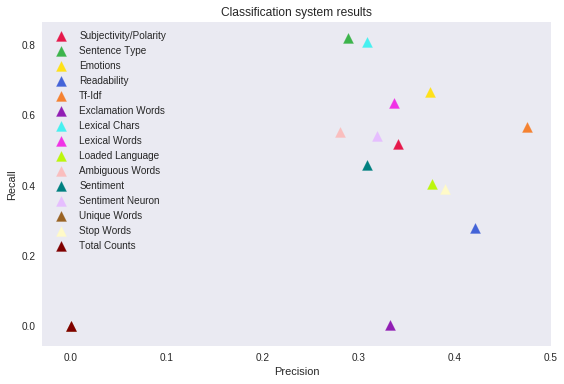

In [0]:
import matplotlib
import matplotlib.pyplot as plt
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
results = []
col_i = 0
plt.figure(0)
for i,n in zip(predictions,names):
    res = [n]
    p = precision_score(y_rest, i, average='binary')
    r = recall_score(y_rest, i, average='binary')
    plt.scatter(p,r, label=n,marker='^', s=100, color=cols[col_i])
    res.append(p)
    res.append(r)
    res.append(f1_score(y_rest, i, average='binary'))
    results.append(res)
    col_i += 1
plt.legend()
plt.title("Classification system results")
plt.xlabel('Precision')
plt.axis('on')
plt.ylabel('Recall')
plt.grid()
plt.tight_layout()
plt.savefig('classification_results.pdf')

In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('emotion_exclamations', False)])

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426



In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('confusing_words', False)])

              precision    recall  f1-score   support

           0       0.72      0.46      0.57      1032
           1       0.28      0.54      0.37       394

   micro avg       0.48      0.48      0.48      1426
   macro avg       0.50      0.50      0.47      1426
weighted avg       0.60      0.48      0.51      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('confusing_words', True)])

              precision    recall  f1-score   support

           0       0.72      0.46      0.57      1032
           1       0.28      0.54      0.37       394

   micro avg       0.48      0.48      0.48      1426
   macro avg       0.50      0.50      0.47      1426
weighted avg       0.60      0.48      0.51      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('emotions', True)])

              precision    recall  f1-score   support

           0       0.82      0.58      0.68      1032
           1       0.37      0.66      0.48       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.60      0.62      0.58      1426
weighted avg       0.69      0.60      0.62      1426



In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('sentence_type', True)])

              precision    recall  f1-score   support

           0       0.76      0.24      0.36      1032
           1       0.29      0.80      0.42       394

   micro avg       0.39      0.39      0.39      1426
   macro avg       0.52      0.52      0.39      1426
weighted avg       0.63      0.39      0.38      1426



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('sentence_type', False)])

              precision    recall  f1-score   support

           0       0.76      0.24      0.36      1032
           1       0.29      0.80      0.42       394

   micro avg       0.39      0.39      0.39      1426
   macro avg       0.52      0.52      0.39      1426
weighted avg       0.63      0.39      0.38      1426



In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('stop_words', True)])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1032
           1       0.39      0.37      0.38       394

   micro avg       0.66      0.66      0.66      1426
   macro avg       0.58      0.57      0.57      1426
weighted avg       0.66      0.66      0.66      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('stop_words', False)])

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1032
           1       0.39      0.37      0.38       394

   micro avg       0.66      0.66      0.66      1426
   macro avg       0.58      0.57      0.57      1426
weighted avg       0.66      0.66      0.66      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), [('pos', False)])

              precision    recall  f1-score   support

           0       0.77      0.68      0.72      1032
           1       0.36      0.47      0.41       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.57      0.58      0.57      1426
weighted avg       0.66      0.62      0.64      1426



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
import itertools
from itertools import combinations

combos_3 = list(itertools.combinations(['subjectivity', 'polarity', 'sentence_type', 'emotions', 'readability', 'tf-idf', 'loaded_words', 'exclamation_words', 'lexical_chars', 'lexical_words', 'emotion_exclamations', 'loaded_language', 'confusing_words', 'sentiment', 'pos', 'unique_words', 'stop_words', 'title_case_words', 'total_counts'], 3))

In [0]:
for c in combos_2:
  print(c)

('subjectivity', 'polarity')
('subjectivity', 'sentence_type')
('subjectivity', 'emotions')
('subjectivity', 'readability')
('subjectivity', 'tf-idf')
('subjectivity', 'loaded_words')
('subjectivity', 'exclamation_words')
('subjectivity', 'lexical_chars')
('subjectivity', 'lexical_words')
('subjectivity', 'emotion_exclamations')
('subjectivity', 'loaded_language')
('subjectivity', 'confusing_words')
('subjectivity', 'sentiment')
('subjectivity', 'pos')
('subjectivity', 'unique_words')
('subjectivity', 'stop_words')
('subjectivity', 'title_case_words')
('subjectivity', 'total_counts')
('polarity', 'sentence_type')
('polarity', 'emotions')
('polarity', 'readability')
('polarity', 'tf-idf')
('polarity', 'loaded_words')
('polarity', 'exclamation_words')
('polarity', 'lexical_chars')
('polarity', 'lexical_words')
('polarity', 'emotion_exclamations')
('polarity', 'loaded_language')
('polarity', 'confusing_words')
('polarity', 'sentiment')
('polarity', 'pos')
('polarity', 'unique_words')
('po

In [0]:
lst_features = [[(x[0], False), (x[1], False), (x[2], False)] for x in combos_3]

In [0]:
for l in lst_features:
  print((l[0][0], l[1][0], l[2][0]))
  train_and_test(LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=SEED), l)

('subjectivity', 'polarity', 'sentence_type')
              precision    recall  f1-score   support

           0       0.77      0.63      0.69      1032
           1       0.34      0.51      0.41       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.57      0.55      1426
weighted avg       0.65      0.60      0.61      1426

('subjectivity', 'polarity', 'emotions')
              precision    recall  f1-score   support

           0       0.82      0.59      0.69      1032
           1       0.38      0.66      0.49       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.60      0.63      0.59      1426
weighted avg       0.70      0.61      0.63      1426

('subjectivity', 'polarity', 'readability')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'polarity', 'tf-idf')
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1032
           1       0.47      0.54      0.50       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.64      0.65      0.65      1426
weighted avg       0.72      0.71      0.71      1426

('subjectivity', 'polarity', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.66      0.71      1032
           1       0.37      0.52      0.43       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.67      0.62      0.63      1426

('subjectivity', 'polarity', 'exclamation_words')
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      1032
           1       0.34      0.51      0.41       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.55      0.56      0.55      1426
weighted avg       0.65      0.59      0.61      1426

('subjectivity', 'polarity', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.79      0.58      0.67      1032
           1       0.35      0.59      0.44       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.57      0.5

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.56      0.66      1032
           1       0.36      0.65      0.47       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.59      0.61      0.57      1426
weighted avg       0.69      0.59      0.61      1426

('subjectivity', 'polarity', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      1032
           1       0.34      0.51      0.41       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.55      0.56      0.55      1426
weighted avg       0.65      0.59      0.61      1426

('subjectivity', 'polarity', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.66      0.71      1032
           1       0.37      0.52      0.43       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.67      0.62      0.63      1426

('subjectivity', 'polarity', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.64      0.70      1032
           1       0.34      0.50      0.41       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.57      0.55      1426
weighted avg       0.65      0.60      0.62      1426

('subjectivity', 'polarity', 'sentiment')
              precision    recall  f1-score   support

           0       0.77      0.63      0.69      1032
           1       0.34      0.50      0.40       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.55      0.56      0.55      1426
weighted avg       0.65      0.59      0.61      1426

('subjectivity', 'polarity', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.67      0.72      1032
           1       0.38      0.53      0.44       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.58      0.60      0.58      1426
weighted avg       0.68      0.63      0.65      1426

('subjectivity', 'polarity', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1032
           1       0.77      0.03      0.05       394

   micro avg       0.73      0.73      0.73      1426
   macro avg       0.75      0.51      0.45      1426
weighted avg       0.74      0.73      0.62      1426

('subjectivity', 'polarity', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1032
           1       0.39      0.45      0.42       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.65      0.66      1426

('subjectivity', 'polarity', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.60      0.67      1032
           1       0.32      0.50      0.39       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.54      0.55      0.53      1426
weighted avg       0.64      0.57      0.59      1426

('subjectivity', 'polarity', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'sentence_type', 'emotions')
              precision    recall  f1-score   support

           0       0.83      0.59      0.69      1032
           1       0.39      0.67      0.49       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.61      0.63      0.59      1426
weighted avg       0.70      0.62      0.64      1426

('subjectivity', 'sentence_type', 'readability')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.25      0.00      0.01       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.49      0.50      0.42      1426
weighted avg       0.59      0.72      0.61      1426

('subjectivity', 'sentence_type', 'tf-idf')
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1032
           1       0.48      0.56      0.52       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.65      0.66      0.66      1426
weighted avg       0.73      0.71      0.72      1426

('subjectivity', 'sentence_type', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.64      0.70      1032
           1       0.34      0.50      0.41       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.57      0.55      1426
weighted avg       0.65      0.60      0.62      1426

('subjectivity', 'sentence_type', 'exclamation_words')
              precision    recall  f1-score   support

           0       0.77      0.57      0.66      1032
           1       0.33      0.56      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.55      0.57      0.54      1426
weighted avg       0.65      0.57      0.59      1426

('subjectivity', 'sentence_type', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.80      0.54      0.65      1032
           1       0.35      0.64      0.45       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.5

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.55      0.66      1032
           1       0.36      0.67      0.47       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.59      0.61      0.56      1426
weighted avg       0.69      0.58      0.61      1426

('subjectivity', 'sentence_type', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.77      0.57      0.66      1032
           1       0.33      0.56      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.55      0.57      0.54      1426
weighted avg       0.65      0.57      0.59      1426

('subjectivity', 'sentence_type', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.64      0.70      1032
           1       0.34      0.50      0.41       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.57      0.55      1426
weighted avg       0.65      0.60      0.62      1426

('subjectivity', 'sentence_type', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.58      0.66      1032
           1       0.34      0.56      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.56      0.57      0.54      1426
weighted avg       0.66      0.57      0.60      1426

('subjectivity', 'sentence_type', 'sentiment')
              precision    recall  f1-score   support

           0       0.78      0.58      0.66      1032
           1       0.34      0.56      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.56      0.57      0.54      1426
weighted avg       0.65      0.57      0.60      1426

('subjectivity', 'sentence_type', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.66      0.72      1032
           1       0.37      0.52      0.43       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.58      0.59      0.57      1426
weighted avg       0.67      0.62      0.64      1426

('subjectivity', 'sentence_type', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.25      0.38      1032
           1       0.30      0.84      0.44       394

   micro avg       0.41      0.41      0.41      1426
   macro avg       0.55      0.55      0.41      1426
weighted avg       0.67      0.41      0.40      1426

('subjectivity', 'sentence_type', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1032
           1       0.55      0.09      0.15       394

   micro avg       0.73      0.73      0.73      1426
   macro avg       0.64      0.53      0.50      1426
weighted avg       0.68      0.73      0.65      1426

('subjectivity', 'sentence_type', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.57      0.65      1032
           1       0.33      0.56      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.55      0.56      0.53      1426
weighted avg       0.65      0.57      0.59      1426

('subjectivity', 'sentence_type', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1032
           1       0.57      0.01      0.02       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.65      0.50      0.43      1426
weighted avg       0.68      0.72      0.61      1426

('subjectivity', 'emotions', 'readability')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.84      0.07      0.12      1032
           1       0.28      0.97      0.44       394

   micro avg       0.32      0.32      0.32      1426
   macro avg       0.56      0.52      0.28      1426
weighted avg       0.69      0.32      0.21      1426

('subjectivity', 'emotions', 'tf-idf')
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1032
           1       0.49      0.56      0.52       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.65      0.67      0.66      1426
weighted avg       0.73      0.72      0.72      1426

('subjectivity', 'emotions', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1032
           1       0.38      0.61      0.47       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.59      0.61      0.58      1426
weighted avg       0.69      0.62      0.63      1426

('subjectivity', 'emotions', 'exclamation_words')
              precision    recall  f1-score   support

           0       0.82      0.59      0.69      1032
           1       0.38      0.67      0.49       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.60      0.63      0.59      1426
weighted avg       0.70      0.61      0.63      1426

('subjectivity', 'emotions', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.83      0.57      0.68      1032
           1       0.38      0.70      0.49       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.61      0.6

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.83      0.59      0.69      1032
           1       0.39      0.68      0.50       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.61      0.64      0.59      1426
weighted avg       0.71      0.62      0.64      1426

('subjectivity', 'emotions', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.82      0.59      0.69      1032
           1       0.38      0.67      0.49       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.60      0.63      0.59      1426
weighted avg       0.70      0.61      0.63      1426

('subjectivity', 'emotions', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1032
           1       0.38      0.61      0.47       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.59      0.61      0.58      1426
weighted avg       0.69      0.62      0.63      1426

('subjectivity', 'emotions', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.59      0.68      1032
           1       0.38      0.66      0.48       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.60      0.62      0.58      1426
weighted avg       0.70      0.61      0.63      1426

('subjectivity', 'emotions', 'sentiment')
              precision    recall  f1-score   support

           0       0.82      0.59      0.68      1032
           1       0.38      0.67      0.49       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.60      0.63      0.59      1426
weighted avg       0.70      0.61      0.63      1426

('subjectivity', 'emotions', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1032
           1       0.39      0.62      0.48       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.60      0.62      0.59      1426
weighted avg       0.69      0.62      0.64      1426

('subjectivity', 'emotions', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1032
           1       0.34      0.04      0.06       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.53      0.50      0.45      1426
weighted avg       0.62      0.71      0.62      1426

('subjectivity', 'emotions', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1032
           1       0.39      0.59      0.47       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.60      0.62      0.60      1426
weighted avg       0.69      0.63      0.65      1426

('subjectivity', 'emotions', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.59      0.69      1032
           1       0.38      0.66      0.48       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.60      0.63      0.59      1426
weighted avg       0.70      0.61      0.63      1426

('subjectivity', 'emotions', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.43      0.01      0.01       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.58      0.50      0.43      1426
weighted avg       0.64      0.72      0.61      1426

('subjectivity', 'readability', 'tf-idf')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1032
           1       0.54      0.48      0.51       394

   micro avg       0.74      0.74      0.74      1426
   macro avg       0.68      0.66      0.67      1426
weighted avg       0.74      0.74      0.74      1426

('subjectivity', 'readability', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1032
           1       0.25      0.22      0.23       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.48      0.48      0.48      1426
weighted avg       0.59      0.60      0.59      1426

('subjectivity', 'readability', 'exclamation_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'readability', 'lexical_chars')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1032
           1       0.38      0.05      0.08       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.55      0.51      0.46      1426
weighted avg       0.63      0.72      0.62      1426

('subjectivity', 'readability', 'lexical_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.98      0.84      1032
           1       0.44      0.04      0.08       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.58      0.51      0.46      1426
weighted avg       0.65      0.72      0.63      1426

('subjectivity', 'readability', 'emotion_exclamations')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'readability', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1032
           1       0.25      0.22      0.23       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.48      0.48      0.48      1426
weighted avg       0.59      0.60      0.59      1426

('subjectivity', 'readability', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.69      0.73      1032
           1       0.35      0.44      0.39       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.56      0.57      0.56      1426
weighted avg       0.65      0.62      0.64      1426

('subjectivity', 'readability', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1032
           1       0.48      0.03      0.05       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.60      0.51      0.45      1426
weighted avg       0.66      0.72      0.62      1426

('subjectivity', 'readability', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1032
           1       0.44      0.02      0.03       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.58      0.50      0.44      1426
weighted avg       0.65      0.72      0.62      1426

('subjectivity', 'readability', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      0.98      0.83      1032
           1       0.15      0.01      0.01       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.44      0.50      0.42      1426
weighted avg       0.56      0.71      0.61      1426

('subjectivity', 'readability', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'readability', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1032
           1       0.42      0.26      0.32       394

   micro avg       0.70      0.70      0.70      1426
   macro avg       0.59      0.56      0.56      1426
weighted avg       0.66      0.70      0.67      1426

('subjectivity', 'readability', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.33      0.01      0.01       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.53      0.50      0.42      1426
weighted avg       0.62      0.72      0.61      1426

('subjectivity', 'tf-idf', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1032
           1       0.48      0.55      0.52       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.65      0.66      0.66      1426
weighted avg       0.73      0.71      0.72      1426

('subjectivity', 'tf-idf', 'exclamation_words')
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1032
           1       0.47      0.54      0.50       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.64      0.65      0.65      1426
weighted avg       0.72      0.71      0.71      1426

('subjectivity', 'tf-idf', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1032
           1       0.47      0.54      0.50       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.64      0.65   

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1032
           1       0.35      0.53      0.42       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.58      0.56      1426
weighted avg       0.66      0.60      0.62      1426

('subjectivity', 'loaded_words', 'lexical_chars')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1032
           1       0.36      0.55      0.44       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.67      0.61      0.62      1426

('subjectivity', 'loaded_words', 'lexical_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.61      0.69      1032
           1       0.36      0.59      0.45       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.58      0.60      0.57      1426
weighted avg       0.68      0.60      0.62      1426

('subjectivity', 'loaded_words', 'emotion_exclamations')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1032
           1       0.35      0.53      0.42       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.58      0.56      1426
weighted avg       0.66      0.60      0.62      1426

('subjectivity', 'loaded_words', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1032
           1       0.35      0.53      0.42       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.57      0.58      0.56      1426
weighted avg       0.66      0.60      0.62      1426

('subjectivity', 'loaded_words', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1032
           1       0.36      0.52      0.42       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.58      0.56      1426
weighted avg       0.66      0.61      0.63      1426

('subjectivity', 'loaded_words', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1032
           1       0.36      0.52      0.42       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.58      0.56      1426
weighted avg       0.66      0.61      0.62      1426

('subjectivity', 'loaded_words', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1032
           1       0.39      0.52      0.45       394

   micro avg       0.64      0.64      0.64      1426
   macro avg       0.59      0.61      0.59      1426
weighted avg       0.68      0.64      0.66      1426

('subjectivity', 'loaded_words', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1032
           1       0.48      0.08      0.13       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.61      0.52      0.48      1426
weighted avg       0.66      0.72      0.64      1426

('subjectivity', 'loaded_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.48      0.60      1032
           1       0.32      0.65      0.43       394

   micro avg       0.53      0.53      0.53      1426
   macro avg       0.55      0.57      0.52      1426
weighted avg       0.66      0.53      0.55      1426

('subjectivity', 'loaded_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.63      0.69      1032
           1       0.35      0.52      0.42       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.58      0.56      1426
weighted avg       0.66      0.60      0.62      1426

('subjectivity', 'loaded_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'exclamation_words', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.80      0.54      0.64      1032
           1       0.35      0.66      0.46       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.58      0.60      0.55      1426
weighted avg       0.68      0.57      0.59      1426

('subjectivity', 'exclamation_words', 'lexical_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.53      0.64      1032
           1       0.36      0.69      0.47       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.59      0.61      0.56      1426
weighted avg       0.69      0.57      0.60      1426

('subjectivity', 'exclamation_words', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.77      0.56      0.65      1032
           1       0.33      0.56      0.42       394

   micro avg       0.56      0.56      0.56      1426
   macro avg       0.55      0.56      0.53      1426
weighted avg       0.65      0.56      0.59      1426

('subjectivity', 'exclamation_words', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1032
           1       0.35      0.53      0.42       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.58      0.56      1426
weighted avg       0.66      0.60      0.62      1426

('subjectivity', 'exclamation_words', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.58      0.66      1032
           1       0.34      0.56      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.55      0.57      0.54      1426
weighted avg       0.65      0.57      0.60      1426

('subjectivity', 'exclamation_words', 'sentiment')
              precision    recall  f1-score   support

           0       0.78      0.58      0.66      1032
           1       0.34      0.57      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.56      0.57      0.54      1426
weighted avg       0.66      0.57      0.60      1426

('subjectivity', 'exclamation_words', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1032
           1       0.36      0.52      0.43       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.66      0.61      0.63      1426

('subjectivity', 'exclamation_words', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'exclamation_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1032
           1       0.38      0.41      0.39       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.57      0.58      0.57      1426
weighted avg       0.66      0.65      0.65      1426

('subjectivity', 'exclamation_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.56      0.65      1032
           1       0.33      0.57      0.42       394

   micro avg       0.56      0.56      0.56      1426
   macro avg       0.55      0.57      0.53      1426
weighted avg       0.65      0.56      0.59      1426

('subjectivity', 'exclamation_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'lexical_chars', 'lexical_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.83      0.52      0.64      1032
           1       0.36      0.71      0.48       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.60      0.62      0.56      1426
weighted avg       0.70      0.58      0.60      1426

('subjectivity', 'lexical_chars', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.80      0.54      0.64      1032
           1       0.35      0.66      0.46       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.58      0.60      0.55      1426
weighted avg       0.68      0.57      0.59      1426

('subjectivity', 'lexical_chars', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1032
           1       0.36      0.55      0.44       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.67      0.61      0.62      1426

('subjectivity', 'lexical_chars', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.55      0.65      1032
           1       0.36      0.66      0.46       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.58      0.60      0.56      1426
weighted avg       0.68      0.58      0.60      1426

('subjectivity', 'lexical_chars', 'sentiment')
              precision    recall  f1-score   support

           0       0.80      0.54      0.65      1032
           1       0.35      0.64      0.45       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.57      0.59      0.55      1426
weighted avg       0.67      0.57      0.59      1426

('subjectivity', 'lexical_chars', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.64      0.71      1032
           1       0.37      0.56      0.45       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.58      0.60      0.58      1426
weighted avg       0.68      0.62      0.63      1426

('subjectivity', 'lexical_chars', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1032
           1       0.50      0.12      0.20       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.62      0.54      0.51      1426
weighted avg       0.67      0.72      0.66      1426

('subjectivity', 'lexical_chars', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1032
           1       0.46      0.21      0.29       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.60      0.56      0.55      1426
weighted avg       0.67      0.71      0.67      1426

('subjectivity', 'lexical_chars', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.53      0.63      1032
           1       0.34      0.64      0.44       394

   micro avg       0.56      0.56      0.56      1426
   macro avg       0.57      0.58      0.54      1426
weighted avg       0.67      0.56      0.58      1426

('subjectivity', 'lexical_chars', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'lexical_words', 'emotion_exclamations')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.53      0.64      1032
           1       0.36      0.69      0.47       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.59      0.61      0.56      1426
weighted avg       0.69      0.57      0.60      1426

('subjectivity', 'lexical_words', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.61      0.69      1032
           1       0.36      0.59      0.45       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.58      0.60      0.57      1426
weighted avg       0.68      0.60      0.62      1426

('subjectivity', 'lexical_words', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.54      0.65      1032
           1       0.37      0.69      0.48       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.59      0.62      0.57      1426
weighted avg       0.70      0.58      0.61      1426

('subjectivity', 'lexical_words', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.53      0.64      1032
           1       0.36      0.68      0.47       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.59      0.61      0.56      1426
weighted avg       0.69      0.57      0.59      1426

('subjectivity', 'lexical_words', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1032
           1       0.38      0.62      0.47       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.60      0.62      0.59      1426
weighted avg       0.69      0.62      0.64      1426

('subjectivity', 'lexical_words', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1032
           1       0.46      0.03      0.06       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.59      0.51      0.45      1426
weighted avg       0.65      0.72      0.62      1426

('subjectivity', 'lexical_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1032
           1       0.40      0.50      0.44       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.59      0.61      0.60      1426
weighted avg       0.68      0.65      0.66      1426

('subjectivity', 'lexical_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.54      0.65      1032
           1       0.36      0.68      0.47       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.59      0.61      0.56      1426
weighted avg       0.69      0.58      0.60      1426

('subjectivity', 'lexical_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.67      0.01      0.01       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.70      0.50      0.42      1426
weighted avg       0.71      0.72      0.61      1426

('subjectivity', 'emotion_exclamations', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1032
           1       0.35      0.53      0.42       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.58      0.56      1426
weighted avg       0.66      0.60      0.62      1426

('subjectivity', 'emotion_exclamations', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.58      0.66      1032
           1       0.34      0.56      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.55      0.57      0.54      1426
weighted avg       0.65      0.57      0.60      1426

('subjectivity', 'emotion_exclamations', 'sentiment')
              precision    recall  f1-score   support

           0       0.78      0.58      0.66      1032
           1       0.34      0.57      0.42       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.56      0.57      0.54      1426
weighted avg       0.66      0.57      0.60      1426

('subjectivity', 'emotion_exclamations', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1032
           1       0.36      0.52      0.43       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.66      0.61      0.63      1426

('subjectivity', 'emotion_exclamations', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'emotion_exclamations', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1032
           1       0.38      0.41      0.39       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.57      0.58      0.57      1426
weighted avg       0.66      0.65      0.65      1426

('subjectivity', 'emotion_exclamations', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.56      0.65      1032
           1       0.33      0.57      0.42       394

   micro avg       0.56      0.56      0.56      1426
   macro avg       0.55      0.57      0.53      1426
weighted avg       0.65      0.56      0.59      1426

('subjectivity', 'emotion_exclamations', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'loaded_language', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1032
           1       0.36      0.52      0.42       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.58      0.56      1426
weighted avg       0.66      0.61      0.63      1426

('subjectivity', 'loaded_language', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1032
           1       0.36      0.52      0.42       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.58      0.56      1426
weighted avg       0.66      0.61      0.62      1426

('subjectivity', 'loaded_language', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1032
           1       0.39      0.52      0.45       394

   micro avg       0.64      0.64      0.64      1426
   macro avg       0.59      0.61      0.59      1426
weighted avg       0.68      0.64      0.66      1426

('subjectivity', 'loaded_language', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1032
           1       0.48      0.08      0.13       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.61      0.52      0.48      1426
weighted avg       0.66      0.72      0.64      1426

('subjectivity', 'loaded_language', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.48      0.60      1032
           1       0.32      0.65      0.43       394

   micro avg       0.53      0.53      0.53      1426
   macro avg       0.55      0.57      0.52      1426
weighted avg       0.66      0.53      0.55      1426

('subjectivity', 'loaded_language', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.63      0.69      1032
           1       0.35      0.52      0.42       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.56      0.58      0.56      1426
weighted avg       0.66      0.60      0.62      1426

('subjectivity', 'loaded_language', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'confusing_words', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.58      0.67      1032
           1       0.34      0.56      0.42       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.56      0.57      0.54      1426
weighted avg       0.65      0.58      0.60      1426

('subjectivity', 'confusing_words', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.66      0.71      1032
           1       0.37      0.52      0.43       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.67      0.62      0.64      1426

('subjectivity', 'confusing_words', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'confusing_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1032
           1       0.38      0.43      0.40       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.57      0.58      0.57      1426
weighted avg       0.66      0.65      0.65      1426

('subjectivity', 'confusing_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.58      0.66      1032
           1       0.33      0.54      0.41       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.55      0.56      0.54      1426
weighted avg       0.65      0.57      0.59      1426

('subjectivity', 'confusing_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'sentiment', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.66      0.71      1032
           1       0.36      0.52      0.43       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.67      0.62      0.63      1426

('subjectivity', 'sentiment', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'sentiment', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1032
           1       0.38      0.44      0.41       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.58      0.58      1426
weighted avg       0.66      0.65      0.65      1426

('subjectivity', 'sentiment', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.57      0.66      1032
           1       0.33      0.55      0.41       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.55      0.56      0.53      1426
weighted avg       0.65      0.57      0.59      1426

('subjectivity', 'sentiment', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'pos', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.93      0.83      1032
           1       0.47      0.16      0.24       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.61      0.55      0.54      1426
weighted avg       0.67      0.72      0.67      1426

('subjectivity', 'pos', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1032
           1       0.39      0.45      0.42       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.59      0.59      1426
weighted avg       0.67      0.65      0.66      1426

('subjectivity', 'pos', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.68      0.72      1032
           1       0.37      0.50      0.43       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.63      0.64      1426

('subjectivity', 'pos', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'unique_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'unique_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'unique_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'stop_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.58      0.66      1032
           1       0.34      0.56      0.42       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.56      0.57      0.54      1426
weighted avg       0.66      0.58      0.60      1426

('subjectivity', 'stop_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('subjectivity', 'title_case_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'sentence_type', 'emotions')
              precision    recall  f1-score   support

           0       0.81      0.58      0.68      1032
           1       0.37      0.65      0.47       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.59      0.62      0.58      1426
weighted avg       0.69      0.60      0.62      1426

('polarity', 'sentence_type', 'readability')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      0.99      0.84      1032
           1       0.30      0.01      0.01       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.51      0.50      0.43      1426
weighted avg       0.61      0.72      0.61      1426

('polarity', 'sentence_type', 'tf-idf')
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1032
           1       0.48      0.55      0.51       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.65      0.66      0.66      1426
weighted avg       0.73      0.71      0.72      1426

('polarity', 'sentence_type', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1032
           1       0.38      0.46      0.42       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.65      0.66      1426

('polarity', 'sentence_type', 'exclamation_words')
              precision    recall  f1-score   support

           0       0.76      0.47      0.58      1032
           1       0.31      0.62      0.41       394

   micro avg       0.51      0.51      0.51      1426
   macro avg       0.53      0.54      0.49      1426
weighted avg       0.64      0.51      0.53      1426

('polarity', 'sentence_type', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.82      0.43      0.57      1032
           1       0.34      0.76      0.47       394

   micro avg       0.52      0.52      0.52      1426
   macro avg       0.58      0

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.56      0.66      1032
           1       0.37      0.67      0.47       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.59      0.61      0.57      1426
weighted avg       0.69      0.59      0.61      1426

('polarity', 'sentence_type', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.76      0.47      0.58      1032
           1       0.31      0.62      0.41       394

   micro avg       0.51      0.51      0.51      1426
   macro avg       0.53      0.54      0.49      1426
weighted avg       0.64      0.51      0.53      1426

('polarity', 'sentence_type', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1032
           1       0.38      0.46      0.42       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.65      0.66      1426

('polarity', 'sentence_type', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.48      0.59      1032
           1       0.31      0.60      0.41       394

   micro avg       0.52      0.52      0.52      1426
   macro avg       0.54      0.54      0.50      1426
weighted avg       0.64      0.52      0.54      1426

('polarity', 'sentence_type', 'sentiment')
              precision    recall  f1-score   support

           0       0.75      0.48      0.59      1032
           1       0.30      0.59      0.40       394

   micro avg       0.51      0.51      0.51      1426
   macro avg       0.53      0.53      0.49      1426
weighted avg       0.63      0.51      0.54      1426

('polarity', 'sentence_type', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1032
           1       0.39      0.50      0.44       394

   micro avg       0.64      0.64      0.64      1426
   macro avg       0.59      0.60      0.59      1426
weighted avg       0.67      0.64      0.65      1426

('polarity', 'sentence_type', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.28      0.42      1032
           1       0.31      0.84      0.45       394

   micro avg       0.44      0.44      0.44      1426
   macro avg       0.56      0.56      0.44      1426
weighted avg       0.68      0.44      0.43      1426

('polarity', 'sentence_type', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1032
           1       0.42      0.44      0.43       394

   micro avg       0.68      0.68      0.68      1426
   macro avg       0.60      0.61      0.60      1426
weighted avg       0.68      0.68      0.68      1426

('polarity', 'sentence_type', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.61      0.67      1032
           1       0.32      0.47      0.38       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.54      0.54      0.53      1426
weighted avg       0.63      0.57      0.59      1426

('polarity', 'sentence_type', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.23      0.36      1032
           1       0.30      0.86      0.45       394

   micro avg       0.41      0.41      0.41      1426
   macro avg       0.56      0.55      0.40      1426
weighted avg       0.67      0.41      0.39      1426

('polarity', 'emotions', 'readability')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1032
           1       0.57      0.03      0.06       394

   micro avg       0.73      0.73      0.73      1426
   macro avg       0.65      0.51      0.45      1426
weighted avg       0.68      0.73      0.62      1426

('polarity', 'emotions', 'tf-idf')
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1032
           1       0.48      0.55      0.51       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.65      0.66      0.65      1426
weighted avg       0.72      0.71      0.72      1426

('polarity', 'emotions', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1032
           1       0.38      0.61      0.47       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.59      0.61      0.58      1426
weighted avg       0.69      0.61      0.63      1426

('polarity', 'emotions', 'exclamation_words')
              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1032
           1       0.37      0.65      0.47       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.59      0.61      0.57      1426
weighted avg       0.69      0.59      0.62      1426

('polarity', 'emotions', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.82      0.57      0.67      1032
           1       0.38      0.68      0.49       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.60      0.63      0

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.58      0.68      1032
           1       0.38      0.67      0.48       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.60      0.62      0.58      1426
weighted avg       0.70      0.60      0.63      1426

('polarity', 'emotions', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1032
           1       0.37      0.65      0.47       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.59      0.61      0.57      1426
weighted avg       0.69      0.59      0.62      1426

('polarity', 'emotions', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1032
           1       0.38      0.61      0.47       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.59      0.61      0.58      1426
weighted avg       0.69      0.61      0.63      1426

('polarity', 'emotions', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1032
           1       0.36      0.64      0.46       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.58      0.61      0.57      1426
weighted avg       0.68      0.59      0.61      1426

('polarity', 'emotions', 'sentiment')
              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1032
           1       0.37      0.65      0.47       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.59      0.61      0.57      1426
weighted avg       0.69      0.60      0.62      1426

('polarity', 'emotions', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.64      0.71      1032
           1       0.39      0.61      0.48       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.60      0.62      0.59      1426
weighted avg       0.69      0.63      0.65      1426

('polarity', 'emotions', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      0.97      0.83      1032
           1       0.30      0.03      0.05       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.51      0.50      0.44      1426
weighted avg       0.61      0.71      0.62      1426

('polarity', 'emotions', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1032
           1       0.42      0.17      0.24       394

   micro avg       0.70      0.70      0.70      1426
   macro avg       0.58      0.54      0.53      1426
weighted avg       0.65      0.70      0.66      1426

('polarity', 'emotions', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1032
           1       0.37      0.65      0.47       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.59      0.61      0.57      1426
weighted avg       0.69      0.60      0.62      1426

('polarity', 'emotions', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.43      0.01      0.01       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.58      0.50      0.43      1426
weighted avg       0.64      0.72      0.61      1426

('polarity', 'readability', 'tf-idf')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.94      0.06      0.11      1032
           1       0.29      0.99      0.44       394

   micro avg       0.31      0.31      0.31      1426
   macro avg       0.61      0.52      0.27      1426
weighted avg       0.76      0.31      0.20      1426

('polarity', 'readability', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1032
           1       0.55      0.03      0.06       394

   micro avg       0.73      0.73      0.73      1426
   macro avg       0.64      0.51      0.45      1426
weighted avg       0.68      0.73      0.62      1426

('polarity', 'readability', 'exclamation_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1032
           1       0.39      0.05      0.09       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.56      0.51      0.46      1426
weighted avg       0.64      0.72      0.63      1426

('polarity', 'readability', 'lexical_chars')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1032
           1       0.25      0.06      0.10       394

   micro avg       0.69      0.69      0.69      1426
   macro avg       0.49      0.50      0.46      1426
weighted avg       0.59      0.69      0.62      1426

('polarity', 'readability', 'lexical_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1032
           1       0.39      0.27      0.32       394

   micro avg       0.68      0.68      0.68      1426
   macro avg       0.57      0.55      0.55      1426
weighted avg       0.65      0.68      0.66      1426

('polarity', 'readability', 'emotion_exclamations')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1032
           1       0.39      0.05      0.09       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.56      0.51      0.46      1426
weighted avg       0.64      0.72      0.63      1426

('polarity', 'readability', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1032
           1       0.55      0.03      0.06       394

   micro avg       0.73      0.73      0.73      1426
   macro avg       0.64      0.51      0.45      1426
weighted avg       0.68      0.73      0.62      1426

('polarity', 'readability', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.50      0.00      0.01       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.61      0.50      0.42      1426
weighted avg       0.66      0.72      0.61      1426

('polarity', 'readability', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.88      0.02      0.04      1032
           1       0.28      0.99      0.44       394

   micro avg       0.29      0.29      0.29      1426
   macro avg       0.58      0.51      0.24      1426
weighted avg       0.72      0.29      0.15      1426

('polarity', 'readability', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.50      0.00      0.00      1032
           1       0.28      1.00      0.43       394

   micro avg       0.28      0.28      0.28      1426
   macro avg       0.39      0.50      0.22      1426
weighted avg       0.44      0.28      0.12      1426

('polarity', 'readability', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.86      0.03      0.06      1032
           1       0.28      0.99      0.44       394

   micro avg       0.29      0.29      0.29      1426
   macro avg       0.57      0.51      0.25      1426
weighted avg       0.70      0.29      0.16      1426

('polarity', 'readability', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.27      0.40      1032
           1       0.29      0.79      0.43       394

   micro avg       0.41      0.41      0.41      1426
   macro avg       0.53      0.53      0.41      1426
weighted avg       0.64      0.41      0.41      1426

('polarity', 'readability', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1032
           1       0.45      0.12      0.19       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.59      0.53      0.51      1426
weighted avg       0.66      0.72      0.65      1426

('polarity', 'readability', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1032
           1       0.60      0.04      0.07       394

   micro avg       0.73      0.73      0.73      1426
   macro avg       0.66      0.51      0.46      1426
weighted avg       0.69      0.73      0.63      1426

('polarity', 'tf-idf', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1032
           1       0.48      0.55      0.51       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.65      0.66      0.65      1426
weighted avg       0.72      0.71      0.72      1426

('polarity', 'tf-idf', 'exclamation_words')
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1032
           1       0.48      0.55      0.51       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.65      0.66      0.65      1426
weighted avg       0.72      0.71      0.72      1426

('polarity', 'tf-idf', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1032
           1       0.47      0.54      0.51       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.64      0.66      0.65 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1032
           1       0.38      0.44      0.41       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.58      0.58      1426
weighted avg       0.67      0.65      0.66      1426

('polarity', 'loaded_words', 'lexical_chars')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1032
           1       0.36      0.54      0.43       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.67      0.61      0.63      1426

('polarity', 'loaded_words', 'lexical_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1032
           1       0.38      0.60      0.47       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.60      0.62      0.59      1426
weighted avg       0.69      0.62      0.64      1426

('polarity', 'loaded_words', 'emotion_exclamations')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1032
           1       0.38      0.44      0.41       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.58      0.58      1426
weighted avg       0.67      0.65      0.66      1426

('polarity', 'loaded_words', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1032
           1       0.38      0.44      0.41       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.65      0.66      1426

('polarity', 'loaded_words', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1032
           1       0.37      0.46      0.41       394

   micro avg       0.64      0.64      0.64      1426
   macro avg       0.57      0.58      0.58      1426
weighted avg       0.66      0.64      0.65      1426

('polarity', 'loaded_words', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1032
           1       0.38      0.46      0.42       394

   micro avg       0.64      0.64      0.64      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.64      0.65      1426

('polarity', 'loaded_words', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1032
           1       0.37      0.48      0.42       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.57      0.59      0.58      1426
weighted avg       0.67      0.63      0.65      1426

('polarity', 'loaded_words', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1032
           1       0.46      0.20      0.28       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.61      0.56      0.55      1426
weighted avg       0.67      0.72      0.67      1426

('polarity', 'loaded_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1032
           1       0.45      0.26      0.33       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.61      0.57      0.57      1426
weighted avg       0.67      0.71      0.68      1426

('polarity', 'loaded_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1032
           1       0.36      0.45      0.40       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.57      0.58      0.57      1426
weighted avg       0.66      0.63      0.64      1426

('polarity', 'loaded_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       1.00      0.00      0.01       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.86      0.50      0.42      1426
weighted avg       0.80      0.72      0.61      1426

('polarity', 'exclamation_words', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.82      0.40      0.54      1032
           1       0.33      0.77      0.46       394

   micro avg       0.50      0.50      0.50      1426
   macro avg       0.57      0.58      0.50      1426
weighted avg       0.68      0.50      0.52      1426

('polarity', 'exclamation_words', 'lexical_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.80      0.55      0.65      1032
           1       0.35      0.64      0.45       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.58      0.59      0.55      1426
weighted avg       0.68      0.57      0.60      1426

('polarity', 'exclamation_words', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.73      0.33      0.46      1032
           1       0.28      0.68      0.40       394

   micro avg       0.43      0.43      0.43      1426
   macro avg       0.51      0.51      0.43      1426
weighted avg       0.61      0.43      0.44      1426

('polarity', 'exclamation_words', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1032
           1       0.38      0.44      0.41       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.58      0.58      1426
weighted avg       0.67      0.65      0.66      1426

('polarity', 'exclamation_words', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.40      0.52      1032
           1       0.29      0.64      0.40       394

   micro avg       0.47      0.47      0.47      1426
   macro avg       0.52      0.52      0.46      1426
weighted avg       0.62      0.47      0.49      1426

('polarity', 'exclamation_words', 'sentiment')
              precision    recall  f1-score   support

           0       0.74      0.43      0.54      1032
           1       0.29      0.60      0.39       394

   micro avg       0.48      0.48      0.48      1426
   macro avg       0.51      0.51      0.46      1426
weighted avg       0.61      0.48      0.50      1426

('polarity', 'exclamation_words', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1032
           1       0.37      0.49      0.42       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.63      0.65      1426

('polarity', 'exclamation_words', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'exclamation_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.65      0.71      1032
           1       0.37      0.54      0.44       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.62      0.64      1426

('polarity', 'exclamation_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1032
           1       0.32      0.42      0.36       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.54      0.54      0.53      1426
weighted avg       0.63      0.60      0.61      1426

('polarity', 'exclamation_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'lexical_chars', 'lexical_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.53      0.64      1032
           1       0.36      0.69      0.47       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.59      0.61      0.56      1426
weighted avg       0.69      0.57      0.59      1426

('polarity', 'lexical_chars', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.82      0.40      0.54      1032
           1       0.33      0.77      0.46       394

   micro avg       0.50      0.50      0.50      1426
   macro avg       0.57      0.58      0.50      1426
weighted avg       0.68      0.50      0.52      1426

('polarity', 'lexical_chars', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1032
           1       0.36      0.54      0.43       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.57      0.59      0.57      1426
weighted avg       0.67      0.61      0.63      1426

('polarity', 'lexical_chars', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.83      0.46      0.59      1032
           1       0.35      0.75      0.47       394

   micro avg       0.54      0.54      0.54      1426
   macro avg       0.59      0.60      0.53      1426
weighted avg       0.69      0.54      0.56      1426

('polarity', 'lexical_chars', 'sentiment')
              precision    recall  f1-score   support

           0       0.81      0.40      0.53      1032
           1       0.32      0.76      0.45       394

   micro avg       0.50      0.50      0.50      1426
   macro avg       0.57      0.58      0.49      1426
weighted avg       0.68      0.50      0.51      1426

('polarity', 'lexical_chars', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1032
           1       0.38      0.54      0.44       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.58      0.60      0.58      1426
weighted avg       0.67      0.63      0.64      1426

('polarity', 'lexical_chars', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.26      0.40      1032
           1       0.30      0.84      0.44       394

   micro avg       0.42      0.42      0.42      1426
   macro avg       0.56      0.55      0.42      1426
weighted avg       0.67      0.42      0.41      1426

('polarity', 'lexical_chars', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1032
           1       0.41      0.45      0.43       394

   micro avg       0.67      0.67      0.67      1426
   macro avg       0.59      0.60      0.60      1426
weighted avg       0.68      0.67      0.67      1426

('polarity', 'lexical_chars', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.47      0.59      1032
           1       0.33      0.68      0.44       394

   micro avg       0.53      0.53      0.53      1426
   macro avg       0.56      0.57      0.52      1426
weighted avg       0.66      0.53      0.55      1426

('polarity', 'lexical_chars', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'lexical_words', 'emotion_exclamations')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.80      0.55      0.65      1032
           1       0.35      0.64      0.45       394

   micro avg       0.57      0.57      0.57      1426
   macro avg       0.58      0.59      0.55      1426
weighted avg       0.68      0.57      0.60      1426

('polarity', 'lexical_words', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1032
           1       0.38      0.60      0.47       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.60      0.62      0.59      1426
weighted avg       0.69      0.62      0.64      1426

('polarity', 'lexical_words', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.56      0.66      1032
           1       0.36      0.66      0.47       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.59      0.61      0.56      1426
weighted avg       0.69      0.58      0.61      1426

('polarity', 'lexical_words', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.80      0.56      0.65      1032
           1       0.35      0.63      0.45       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.57      0.59      0.55      1426
weighted avg       0.67      0.58      0.60      1426

('polarity', 'lexical_words', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.80      0.62      0.70      1032
           1       0.37      0.59      0.46       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.59      0.61      0.58      1426
weighted avg       0.68      0.61      0.63      1426

('polarity', 'lexical_words', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.84      0.44      0.57      1032
           1       0.35      0.78      0.48       394

   micro avg       0.53      0.53      0.53      1426
   macro avg       0.59      0.61      0.53      1426
weighted avg       0.70      0.53      0.55      1426

('polarity', 'lexical_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1032
           1       0.42      0.51      0.46       394

   micro avg       0.67      0.67      0.67      1426
   macro avg       0.61      0.62      0.61      1426
weighted avg       0.69      0.67      0.68      1426

('polarity', 'lexical_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.54      0.65      1032
           1       0.36      0.68      0.47       394

   micro avg       0.58      0.58      0.58      1426
   macro avg       0.59      0.61      0.56      1426
weighted avg       0.69      0.58      0.60      1426

('polarity', 'lexical_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1032
           1       0.80      0.01      0.02       394

   micro avg       0.73      0.73      0.73      1426
   macro avg       0.76      0.50      0.43      1426
weighted avg       0.75      0.73      0.61      1426

('polarity', 'emotion_exclamations', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1032
           1       0.38      0.44      0.41       394

   micro avg       0.65      0.65      0.65      1426
   macro avg       0.58      0.58      0.58      1426
weighted avg       0.67      0.65      0.66      1426

('polarity', 'emotion_exclamations', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.40      0.52      1032
           1       0.29      0.64      0.40       394

   micro avg       0.47      0.47      0.47      1426
   macro avg       0.52      0.52      0.46      1426
weighted avg       0.62      0.47      0.49      1426

('polarity', 'emotion_exclamations', 'sentiment')
              precision    recall  f1-score   support

           0       0.74      0.43      0.54      1032
           1       0.29      0.60      0.39       394

   micro avg       0.48      0.48      0.48      1426
   macro avg       0.51      0.51      0.46      1426
weighted avg       0.61      0.48      0.50      1426

('polarity', 'emotion_exclamations', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1032
           1       0.37      0.49      0.42       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.63      0.65      1426

('polarity', 'emotion_exclamations', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'emotion_exclamations', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.79      0.65      0.71      1032
           1       0.37      0.54      0.44       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.62      0.64      1426

('polarity', 'emotion_exclamations', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1032
           1       0.32      0.42      0.36       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.54      0.54      0.53      1426
weighted avg       0.63      0.60      0.61      1426

('polarity', 'emotion_exclamations', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'loaded_language', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1032
           1       0.37      0.46      0.41       394

   micro avg       0.64      0.64      0.64      1426
   macro avg       0.57      0.58      0.58      1426
weighted avg       0.66      0.64      0.65      1426

('polarity', 'loaded_language', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1032
           1       0.38      0.46      0.42       394

   micro avg       0.64      0.64      0.64      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.64      0.65      1426

('polarity', 'loaded_language', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1032
           1       0.37      0.48      0.42       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.57      0.59      0.58      1426
weighted avg       0.67      0.63      0.65      1426

('polarity', 'loaded_language', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1032
           1       0.46      0.20      0.28       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.61      0.56      0.55      1426
weighted avg       0.67      0.72      0.67      1426

('polarity', 'loaded_language', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1032
           1       0.45      0.26      0.33       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.61      0.57      0.57      1426
weighted avg       0.67      0.71      0.68      1426

('polarity', 'loaded_language', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1032
           1       0.36      0.45      0.40       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.57      0.58      0.57      1426
weighted avg       0.66      0.63      0.64      1426

('polarity', 'loaded_language', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       1.00      0.00      0.01       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.86      0.50      0.42      1426
weighted avg       0.80      0.72      0.61      1426

('polarity', 'confusing_words', 'sentiment')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.46      0.57      1032
           1       0.29      0.57      0.38       394

   micro avg       0.49      0.49      0.49      1426
   macro avg       0.51      0.52      0.48      1426
weighted avg       0.61      0.49      0.52      1426

('polarity', 'confusing_words', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1032
           1       0.37      0.49      0.42       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.63      0.65      1426

('polarity', 'confusing_words', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.80      0.22      0.35      1032
           1       0.29      0.85      0.44       394

   micro avg       0.40      0.40      0.40      1426
   macro avg       0.55      0.54      0.39      1426
weighted avg       0.66      0.40      0.37      1426

('polarity', 'confusing_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1032
           1       0.41      0.41      0.41       394

   micro avg       0.68      0.68      0.68      1426
   macro avg       0.59      0.59      0.59      1426
weighted avg       0.67      0.68      0.68      1426

('polarity', 'confusing_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1032
           1       0.32      0.42      0.36       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.53      0.54      0.53      1426
weighted avg       0.63      0.60      0.61      1426

('polarity', 'confusing_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'sentiment', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1032
           1       0.37      0.49      0.42       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.63      0.64      1426

('polarity', 'sentiment', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'sentiment', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1032
           1       0.42      0.45      0.43       394

   micro avg       0.67      0.67      0.67      1426
   macro avg       0.60      0.60      0.60      1426
weighted avg       0.68      0.67      0.68      1426

('polarity', 'sentiment', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1032
           1       0.32      0.43      0.37       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.54      0.54      0.53      1426
weighted avg       0.63      0.59      0.61      1426

('polarity', 'sentiment', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'pos', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1032
           1       0.48      0.20      0.28       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.62      0.56      0.55      1426
weighted avg       0.68      0.72      0.68      1426

('polarity', 'pos', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1032
           1       0.47      0.10      0.17       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.60      0.53      0.50      1426
weighted avg       0.66      0.72      0.65      1426

('polarity', 'pos', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1032
           1       0.38      0.48      0.43       394

   micro avg       0.64      0.64      0.64      1426
   macro avg       0.58      0.59      0.58      1426
weighted avg       0.67      0.64      0.65      1426

('polarity', 'pos', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'unique_words', 'stop_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1032
           1       0.41      0.43      0.42       394

   micro avg       0.67      0.67      0.67      1426
   macro avg       0.59      0.60      0.59      1426
weighted avg       0.68      0.67      0.67      1426

('polarity', 'unique_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'unique_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'stop_words', 'title_case_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.78      0.61      0.68      1032
           1       0.35      0.55      0.43       394

   micro avg       0.59      0.59      0.59      1426
   macro avg       0.57      0.58      0.56      1426
weighted avg       0.66      0.59      0.61      1426

('polarity', 'stop_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('polarity', 'title_case_words', 'total_counts')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1032
           1       0.00      0.00      0.00       394

   micro avg       0.72      0.72      0.72      1426
   macro avg       0.36      0.50      0.42      1426
weighted avg       0.52      0.72      0.61      1426

('sentence_type', 'emotions', 'readability')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.80      0.07      0.13      1032
           1       0.28      0.95      0.43       394

   micro avg       0.32      0.32      0.32      1426
   macro avg       0.54      0.51      0.28      1426
weighted avg       0.66      0.32      0.22      1426

('sentence_type', 'emotions', 'tf-idf')
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1032
           1       0.49      0.56      0.52       394

   micro avg       0.71      0.71      0.71      1426
   macro avg       0.65      0.67      0.66      1426
weighted avg       0.73      0.71      0.72      1426

('sentence_type', 'emotions', 'loaded_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1032
           1       0.38      0.61      0.47       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.60      0.62      0.59      1426
weighted avg       0.69      0.62      0.64      1426

('sentence_type', 'emotions', 'exclamation_words')
              precision    recall  f1-score   support

           0       0.81      0.58      0.68      1032
           1       0.37      0.65      0.47       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.59      0.62      0.58      1426
weighted avg       0.69      0.60      0.62      1426

('sentence_type', 'emotions', 'lexical_chars')
              precision    recall  f1-score   support

           0       0.83      0.58      0.68      1032
           1       0.38      0.68      0.49       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.60      0

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.59      0.69      1032
           1       0.38      0.66      0.49       394

   micro avg       0.61      0.61      0.61      1426
   macro avg       0.60      0.63      0.59      1426
weighted avg       0.70      0.61      0.63      1426

('sentence_type', 'emotions', 'emotion_exclamations')
              precision    recall  f1-score   support

           0       0.81      0.58      0.68      1032
           1       0.37      0.65      0.47       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.59      0.62      0.58      1426
weighted avg       0.69      0.60      0.62      1426

('sentence_type', 'emotions', 'loaded_language')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1032
           1       0.38      0.61      0.47       394

   micro avg       0.62      0.62      0.62      1426
   macro avg       0.60      0.62      0.59      1426
weighted avg       0.69      0.62      0.64      1426

('sentence_type', 'emotions', 'confusing_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.59      0.68      1032
           1       0.37      0.64      0.47       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.59      0.61      0.57      1426
weighted avg       0.69      0.60      0.62      1426

('sentence_type', 'emotions', 'sentiment')
              precision    recall  f1-score   support

           0       0.81      0.58      0.68      1032
           1       0.37      0.65      0.47       394

   micro avg       0.60      0.60      0.60      1426
   macro avg       0.59      0.62      0.58      1426
weighted avg       0.69      0.60      0.62      1426

('sentence_type', 'emotions', 'pos')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1032
           1       0.39      0.62      0.48       394

   micro avg       0.63      0.63      0.63      1426
   macro avg       0.60      0.63      0.60      1426
weighted avg       0.70      0.63      0.65      1426

('sentence_type', 'emotions', 'unique_words')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1032
           1       0.42      0.30      0.35       394

   micro avg       0.69      0.69      0.69      1426
   macro avg       0.59      0.57      0.57      1426
weighted avg       0.67      0.69      0.68      1426

('sentence_type', 'emotions', 'stop_words')


KeyboardInterrupt: ignored

In [0]:
!git clone https://github.com/openai/generating-reviews-discovering-sentiment.git

Cloning into 'generating-reviews-discovering-sentiment'...
remote: Enumerating objects: 63, done.
remote: Total 63 (delta 0), reused 0 (delta 0), pack-reused 63
Unpacking objects: 100% (63/63), done.
Checking out files: 100% (24/24), done.


In [0]:
# from encoder import Model

# model = Model()

ModuleNotFoundError: ignored

In [0]:
%cd generating-reviews-discovering-sentiment
!pip install tqdm


/content/generating-reviews-discovering-sentiment


In [0]:
from encoder import Model

model = Model()

Instructions for updating:
dim is deprecated, use axis instead


In [0]:
text_features = model.transform([
    'the food was hot and the service was fast!'
])


0.203 seconds to transform 1 examples


In [0]:
print(text_features[:, 2388])


[0.53051543]
